# Earthquake Location and Re-location using Automatic Differentiation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

### Generate synthetic travel-time measurements

In [2]:
np.random.seed(11)
vp = 6.0
vs = vp/1.73
num_station = 5
num_event = 30
xmax = 100
station_loc = np.random.uniform(low=0, high=xmax, size=(num_station,3))
station_loc[:, 2] = 0
station_dt = (np.random.rand(num_station, 1)-0.5)*2 * 1.0
event_loc = np.random.uniform(low=0, high=xmax, size=(num_event,3))
event_loc[:, 2] = 0
event_time = np.random.uniform(low=0, high=xmax/vp, size=(num_event,1))

# %%
event_index = []
station_index = []
phase_type = []
phase_time = []
phase_weight = []
velocity = {"P": vp, "S": vs}
random_time = (np.random.rand(1, num_station, 2) - 0.5)*2.0 * 3.0
for evid in range(num_event):
    for stid in range(num_station):
        for i, phase in enumerate(["P", "S"]):
            event_index.append(evid)
            station_index.append(stid)
            phase_type.append(phase)
            dist = np.linalg.norm(station_loc[stid] - event_loc[evid], axis=-1)
            t = dist / velocity[phase] + event_time[evid] + random_time[0, stid, i] + station_dt[stid]
            phase_time.append(t)
            phase_weight.append(1.0)

event_index = torch.tensor(np.array(event_index, dtype=np.int64))
station_index = torch.tensor(np.array(station_index, dtype=np.int64))
phase_time = torch.tensor(np.array(phase_time, dtype=np.float32))
phase_weight = torch.tensor(np.array(phase_weight, dtype=np.float32))

Visualize travel-time of the first event

[10 11 12 13 14 15 16 17 18 19]


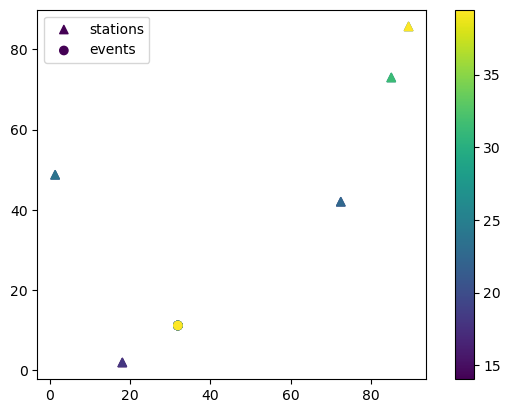

In [3]:
plt.figure()
idx = np.arange(len(event_index))[event_index == event_index[10]]
print(idx)
plt.scatter(station_loc[station_index[idx], 0], station_loc[station_index[idx], 1], c=phase_time[idx], marker="^", label="stations")
plt.scatter(event_loc[event_index[idx], 0], event_loc[event_index[idx], 1], c=phase_time[idx], marker="o", label="events")
plt.xlim([0, xmax])
plt.ylim([0, xmax])
plt.legend()
plt.colorbar()
plt.axis("scaled")
plt.show()

### Build forward model for calculating travel-times

In [4]:
class TravelTime(nn.Module):

    def __init__(self, num_event, num_station, station_loc, station_dt=None, event_loc=None, event_time=None, reg=0.001, velocity={"P": 6.0, "S": 6.0/1.73}, dtype=torch.float32):
        super().__init__()
        self.num_event = num_event
        self.event_loc = nn.Embedding(num_event, 3)
        self.event_time = nn.Embedding(num_event, 1)
        self.station_dt = nn.Embedding(num_station, 1)
        if station_dt is None:
            init.constant_(self.station_dt.weight.data, val=0.0)
        else:
            self.station_dt.from_pretrained(torch.tensor(station_dt, dtype=dtype))
        self.register_buffer('station_loc', torch.tensor(station_loc, dtype=dtype))
        self.velocity = velocity
        self.reg = reg
        if event_loc is not None:
            self.event_loc.from_pretrained(torch.tensor(event_loc, dtype=dtype))
        if event_time is not None:
            self.event_time.from_pretrained(torch.tensor(event_time, dtype=dtype))

    def calc_time(self, event_loc, station_loc, phase_type):

        dist  = torch.linalg.norm(event_loc - station_loc, axis=-1, keepdim=True)
        vel = self.velocity
        tt = dist / torch.tensor([vel[p] for p in phase_type]).unsqueeze(-1)

        return tt
    
    def forward(self, station_index, event_index=None, phase_type=None, phase_time=None, phase_weight=None, use_pair=False):

        station_loc = self.station_loc[station_index]
        station_dt = self.station_dt(station_index)

        event_loc = self.event_loc(event_index)
        event_time = self.event_time(event_index)

        tt = self.calc_time(event_loc, station_loc, phase_type)
        t = event_time + tt + station_dt

        if use_pair:
            t = t[0] - t[1]

        if phase_time is None:
            loss = None
        else:
            # loss = torch.mean(phase_weight * (t - phase_time) ** 2)
            loss = torch.mean(F.huber_loss(t, phase_time, reduction="none") * phase_weight)
            loss += self.reg * torch.mean(torch.abs(station_dt)) ## prevent the trade-off between station_dt and event_time

        return {"phase_time": t, "loss": loss}

### Locating earthquakes using absolute travel times

In [5]:
# %%
travel_time = TravelTime(num_event, num_station, station_loc, station_dt=station_dt, event_loc=event_loc, event_time=event_time, reg=0, velocity={"P": vp, "S": vs})
tt = travel_time(station_index, event_index, phase_type)["phase_time"]
print("True location: ", F.mse_loss(tt, phase_time))

# %%
travel_time = TravelTime(num_event, num_station, station_loc, velocity={"P": vp, "S": vs})
tt = travel_time(station_index, event_index, phase_type)["phase_time"]
print("Initial loss", F.mse_loss(tt, phase_time))
init_event_loc = travel_time.event_loc.weight.clone().detach().numpy()
init_event_time = travel_time.event_time.weight.clone().detach().numpy()

# %%
optimizer = optim.LBFGS(params=travel_time.parameters(), max_iter=1000, line_search_fn="strong_wolfe")

def closure():
    optimizer.zero_grad()
    loss = travel_time(station_index, event_index, phase_type, phase_time, phase_weight)["loss"]
    loss.backward()
    return loss

optimizer.step(closure)
    
tt = travel_time(station_index, event_index, phase_type)["phase_time"]
print("Optimized loss", F.mse_loss(tt, phase_time))
invert_event_loc = travel_time.event_loc.weight.clone().detach().numpy()
invert_event_time = travel_time.event_time.weight.clone().detach().numpy()
invert_station_dt = travel_time.station_dt.weight.clone().detach().numpy()


True location:  tensor(227.6136, grad_fn=<MseLossBackward0>)
Initial loss tensor(231.3326, grad_fn=<MseLossBackward0>)
Optimized loss tensor(2.1605, grad_fn=<MseLossBackward0>)


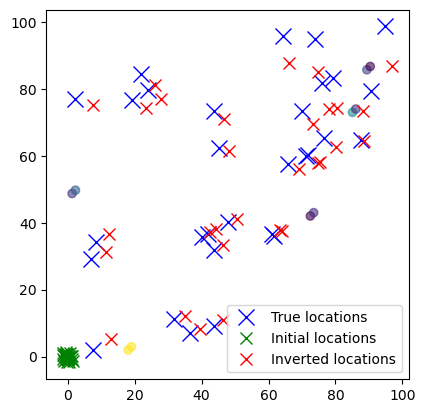

In [6]:
# %%
plt.figure()
# plt.scatter(station_loc[:,0], station_loc[:,1], c=tp[idx_event,:])
plt.plot(event_loc[:,0], event_loc[:,1], 'x', markersize=12, color='blue', label="True locations")
plt.plot(init_event_loc[:,0], init_event_loc[:,1], 'x', markersize=8, color='green', label="Initial locations")
plt.plot(invert_event_loc[:,0], invert_event_loc[:,1], 'x', markersize=8, color='red', label="Inverted locations")
plt.scatter(station_loc[:,0], station_loc[:,1], c=station_dt, marker="o", alpha=0.6)
plt.scatter(station_loc[:,0]+1, station_loc[:,1]+1, c=invert_station_dt, marker="o",  alpha=0.6)
plt.xlim([0, xmax])
plt.ylim([0, xmax])
plt.axis("scaled")
plt.legend()
# plt.savefig("absolute_location.png", dpi=300)
plt.show()

### Locating earthquakes using both absolute travel-times and relative travel-time differences

In [7]:
# %%
pair_event_index = []
pair_station_index = []
pair_type = []
pair_dtime = []
pair_weight = []
velocity = {"P": vp, "S": vs}
for evid1 in range(num_event):
    for evid2 in range(evid1+1, num_event):
        for stid in range(num_station):
            for phase in ["P", "S"]:
                pair_event_index.append([evid1, evid2])
                pair_station_index.append(stid)
                pair_type.append(phase)
                dist1 = np.linalg.norm(station_loc[stid] - event_loc[evid1], axis=-1)
                tt1 = dist1 / velocity[phase] 
                t1 = tt1 + event_time[evid1] + random_time[0, stid, i]
                dist2 = np.linalg.norm(station_loc[stid] - event_loc[evid2], axis=-1)
                tt2 = dist2 / velocity[phase] 
                t2 = tt2 + event_time[evid2] + random_time[0, stid, i]
                pair_dtime.append(t1 - t2)
                pair_weight.append(1.0)

pair_event_index = torch.tensor(np.array(pair_event_index, dtype=np.int64).T)
pair_station_index = torch.tensor(np.array(pair_station_index, dtype=np.int64))
pair_dtime = torch.tensor(np.array(pair_dtime, dtype=np.float32))
pair_weight = torch.tensor(np.array(pair_weight, dtype=np.float32))


# %%
travel_time = TravelTime(num_event, num_station, station_loc, station_dt=station_dt, event_loc=event_loc, event_time=event_time, reg=0, velocity={"P": vp, "S": vs})
dt = travel_time(pair_station_index, pair_event_index, pair_type, use_pair=True)["phase_time"]
print("True location: ", F.mse_loss(dt, pair_dtime))

# %%
travel_time = TravelTime(num_event, num_station, station_loc, velocity={"P": vp, "S": vs})
tt = travel_time(pair_station_index, pair_event_index, pair_type, pair_dtime, pair_weight, use_pair=True)["phase_time"]
print("Initial loss", F.mse_loss(tt, pair_dtime))
init_event_loc = travel_time.event_loc.weight.clone().detach().numpy()
init_event_time = travel_time.event_time.weight.clone().detach().numpy()

# %%
optimizer = optim.LBFGS(params=travel_time.parameters(), max_iter=1000, line_search_fn="strong_wolfe")

def closure():
    optimizer.zero_grad()
    loss = travel_time(pair_station_index, pair_event_index, pair_type, pair_dtime, pair_weight, use_pair=True)["loss"]
    loss.backward()
    return loss

optimizer.step(closure)
    
tt = travel_time(pair_station_index, pair_event_index, pair_type, use_pair=True)["phase_time"]
print("Optimized loss", F.mse_loss(tt, pair_dtime))
invert_event_loc = travel_time.event_loc.weight.clone().detach().numpy()
invert_event_time = travel_time.event_time.weight.clone().detach().numpy()


True location:  tensor(124.2226, grad_fn=<MseLossBackward0>)
Initial loss tensor(120.1657, grad_fn=<MseLossBackward0>)
Optimized loss tensor(5.7172e-07, grad_fn=<MseLossBackward0>)


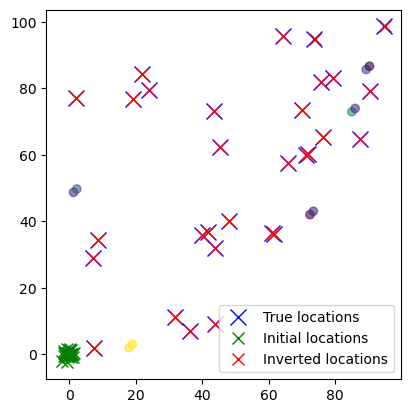

In [8]:
# %%
plt.figure()
plt.plot(event_loc[:,0], event_loc[:,1], 'x', markersize=12, color='blue', label="True locations")
plt.plot(init_event_loc[:,0], init_event_loc[:,1], 'x', markersize=8, color='green', label="Initial locations")
plt.plot(invert_event_loc[:,0], invert_event_loc[:,1], 'x', markersize=8, color='red', label="Inverted locations")
plt.scatter(station_loc[:,0], station_loc[:,1], c=station_dt, marker="o", alpha=0.6)
plt.scatter(station_loc[:,0]+1, station_loc[:,1]+1, c=invert_station_dt, marker="o",  alpha=0.6)
plt.xlim([0, xmax])
plt.ylim([0, xmax])
plt.axis("scaled")
plt.legend()
# plt.savefig("relative_location.png", dpi=300)
plt.show()